<div style="text-align: center">
<img src="figs/stroke_logo.png" width="350px" />
</div>

# RAMP: segmentation of the brain lesions

<br>
<div style="text-align: left">
    <em>
        <i>Authors: Maria Teleńczuk, Swetha Shankar, Lucy Liu, Guillaume Lemaitre, Alexandre Gramfort</i>
        <a href="http://www.datascience-paris-saclay.fr">Paris-Saclay Center for Data Science</a> (Inria), France<br>
    </em>
    <em>  
        <i>Sook-Lei Liew</i>
        <a href="https://chan.usc.edu/npnl/">Neural Plasticity & Neurorehabilitation Lab</a> (USC), USA<br>
        </em>
        
</div>

# Table of contents
1. [Introduction](#Introduction)
3. [Submission](#Submission) 

# Introduction <a class="anchor" id="Introduction"></a>

Stroke is the leading cause of adult disability worldwide, with up to two-thirds of individuals experiencing long-term disabilities. Large-scale neuroimaging studies have shown promise in identifying robust biomarkers (e.g., measures of brain structure) of stroke recovery. However, analyzing large datasets is problematic due to barriers in accurate stroke lesion segmentation. Manually-traced lesions are currently the gold standard for lesion segmentation, but are labor intensive and require anatomical expertise. While algorithms have been developed to automate this process, the results often lack accuracy. Newer algorithms that employ machine-learning techniques are promising, yet these require large training datasets to optimize performance.<br>

More information:
<a href="http://fcon_1000.projects.nitrc.org/indi/retro/atlas.html">Anatomical Tracings of Lesions After Stroke</a>

## References

<a href="https://www.sciencedirect.com/science/article/abs/pii/S1361841516301268">1. Maier, Oskar, et al. "ISLES 2015-A public evaluation benchmark for ischemic stroke lesion segmentation from multispectral MRI." Medical image analysis 35 (2017): 250-269.</a><br>

<a href="https://www.nature.com/articles/sdata201811">2. Liew, Sook-Lei, et al. "A large, open source dataset of stroke anatomical brain images and manual lesion segmentations." Scientific data 5 (2018): 180011.</a><br>


In this challenge you will be given 3D medical images (T1 MRI scans) of the stroke patients and the files with the corresponding lesions (binary masks) traced by hand by experts. Your algorithm will be scored on the timing and the precision. Before we look closer at the data, let's import all the necessary libraries (feel skip this step if you have done it already):

# Imports

### Prerequisites

- Python >= 3.7
- [nilearn](https://nilearn.github.io/)
- [numpy](https://pypi.org/project/numpy/)
- [scipy](https://pypi.org/project/scipy/)
- [pandas](https://pypi.org/project/pandas/)
- [scikit-learn](https://pypi.org/project/scikit-learn/)
- [matplolib](https://pypi.org/project/matplotlib/)
- [jupyter](https://pypi.org/project/jupyter/)
- [ramp-workflow](https://pypi.org/project/ramp-workflow/)
- [ramp-utils](https://github.com/paris-saclay-cds/ramp-board/)

The following cell will install the required pacakge dependencies, if necessary.

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install ramp-workflow
!{sys.executable} -m pip install ramp-utils

To get this notebook running and test your models locally using `ramp-test` (from ramp-workflow), we recommend that you use the Anaconda or Miniconda Python distribution.

# Data exploration

## download the data

### TODO: script to download the data

## viewing the data files

In your `data` folder you should now be able to find the directories with names: `subject_1`, `subject_2` and so on. Inside each of them you will find two files: `t1.nii.gz` and `truth.nii.gz`:
 - `t1.nii.gz` is a file with a 3D T1 (MRI) brain scan of the patient
 - `truth.nii.gz` is a file with the binary mask of the same size as T1 image. 0 corresponds to no lesion, 1 corresponds to the lesion. The true lesions where traced by the experts by hand

If you wish to view any of those files from outside of Python, there are many applications available online. For example you might want to use [ITK-snap](http://www.itksnap.org/pmwiki/pmwiki.php). There, you can load the `t1.nii.gz` as a Main Image and `truth.nii.gz` as a Segmentation to overlap the two. Here, we won't go into the details of how to use ITK-snap.

To load the images to Python, we will be using [Nilearn](https://nilearn.github.io/) Python library, but there are many other possiblities so feel free to choose your favorite one (if, for your submission, you will want to use a libarary which is not included within the `environment.yml` feel free to contact us and, if reasonable, we will add it).

## View data

[MRI](https://en.wikipedia.org/wiki/Magnetic_resonance_imaging#:~:text=Magnetic%20resonance%20imaging%20(MRI)%20is,the%20organs%20in%20the%20body.) is short for the magnetic resonance imaging. MRI images consist of scans of the brain at different depths and then combined together to form the 3d image of the brain. 

Let's view few of the images:


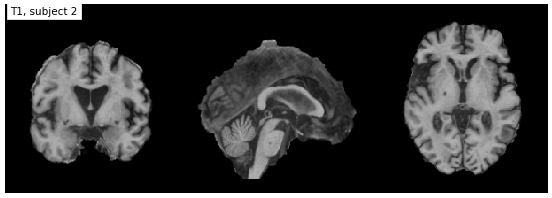

In [73]:
%matplotlib inline

from nilearn import plotting
import os
import matplotlib.pylab as plt

def plot_t1(path_to_t1, title='T1'):
    fig = plt.figure(1, figsize=(14, 5), frameon=False, dpi=50)
    ax = plt.gca()
    plotting.plot_anat(path_to_t1, title=title,
                       axes=ax,
                       draw_cross=False,
                       annotate=False,
                       cut_coords=(0, 0, 0)
                       )
plot_t1(path_to_t1='data/subject_2/T1.nii.gz',
        title='T1, subject 2')
# TODO: choose the images with 1) no visible lesion; 2) small lesion; 3) large lesion

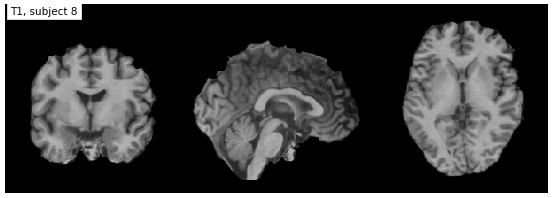

In [74]:
plot_t1(path_to_t1='data/subject_8/T1.nii.gz',
        title='T1, subject 8')

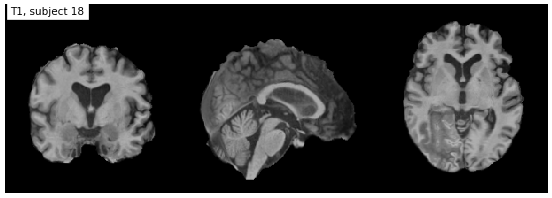

In [75]:
plot_t1(path_to_t1='data/subject_18/T1.nii.gz',
        title='T1, subject 18')

We plotted the T1 image for three different subjects shown at three different axes. As you might have noticed some preprocessing has been done already. We used the following preprocessing steps to obtain the above images:

1. First as described [here](https://www.nature.com/articles/sdata201811) TODO: go into the details
2. And in addition:
    - skull was removed
    - bias was corrected
    - images were aligned to MNI space

Can you already make some guesses on where the lesions are located? Let's overlap them with the anatomical image:

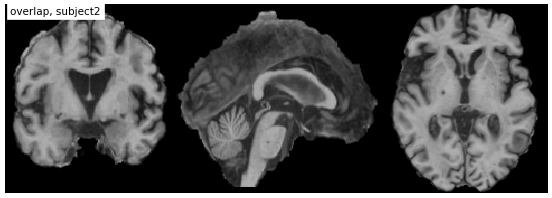

In [79]:
def plot_overlap(path_to_t1, path_to_lesion, title='overlap'):
    fig = plt.figure(1, figsize=(14, 5), frameon=False, dpi=50)
    ax = plt.gca()
    plotting.plot_roi(path_to_lesion, path_to_t1, title=title,
                       axes=ax,
                       draw_cross=False,
                       annotate=False, 
                       cmap='autumn',
                       cut_coords=(0, 0, 0)
                       )
plot_overlap(path_to_t1='data/subject_2/T1.nii.gz',
             path_to_lesion='data/subject_2/truth.nii.gz',
             title='overlap, subject2')

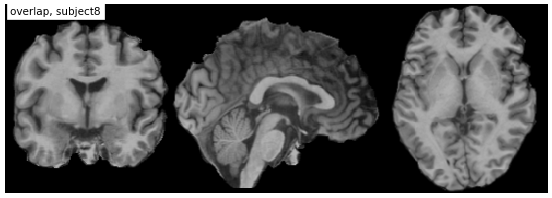

In [80]:
plot_overlap(path_to_t1='data/subject_8/T1.nii.gz',
             path_to_lesion='data/subject_8/truth.nii.gz',
             title='overlap, subject8')

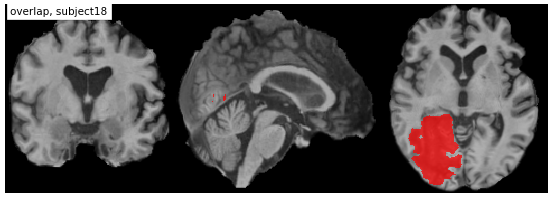

In [81]:
plot_overlap(path_to_t1='data/subject_18/T1.nii.gz',
             path_to_lesion='data/subject_18/truth.nii.gz',
             title='overlap, subject18')

Did you guess correctly the locations of the lesions? What else did you notice?

Probably the most noticable thing is that the lesions are not of the same size nor they are in the location. In one of the subjects lesion is not even in the plane that we are looking at, or is it there at all?

Feel free to look at the data of other subjects as well, you can also view different planes by changing `cut_coords` parameter.

Lets now look at the voxel sizes of the lesions of some patients (for the sake of time we are not looking at all of them here)

## TODO: plot few other brain images and the template image

TODO: plot the same images with the mask overlaps

## todo: why do we not see the mask on some?

In [4]:
## TODO: suggest using itk-snap

## TODO: (hidden) script for making a movie + show the movie

## read the masks + show the difference in the mask sizes

sample example script: average the brains or use template to subtracted and see if we get the lesion

## 2. scikit image image segmentation example??

## deep learning possible ideas

In [5]:
## here we adapted the unet algorithm, explain unet, references etc

Training the model with fit (in the starting kit example, we load some pretrained weights to be able to show results here, but note this is not possible for an actual submission):

    predict few of the images

show the score

In [6]:
Explain how to make the submission

SyntaxError: invalid syntax (<ipython-input-6-0b8750893509>, line 1)

explain potential possiblity to use AWS services/ limits

## Submission <a class="anchor" id="Submission"></a> 

Once you found a good model you wish to test you should place it in a directory, naming it as you wish, and place it in the `submissions/` folder (you can already find there two submissions in the folders `submissions/starting_kit` and `submissions/lasso_lars` which we talked about above). The file placed in your submission directory (e.g., `starting_kit/` should be called `estimator.py` and should define a function called `get_estimator` that returns a scikit-learn type of pipeline.

You can then test your submission locally using the command:

`ramp-test --submission <your submission folder name>`

if you prefer to run a quick test on much smaller subset of data you can add `--quick-test` option:

`ramp-test --submission <your submission folder name> --quick-test`


For more information on how to submit your code on [ramp.studio](https://ramp.studio/), refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).